# PropDRM - deep learning from propositionalized data structures

This notebook serves as an illustratory example of the PropDRM approach [[1]](#fn1). The key idea of PropDRM builds on the concept of Wordification, coupled with deep neural networks. The implementation in this notebook illustrates the key ideas of PropDRM on the [mutagenesis](https://relational.fit.cvut.cz/dataset/Mutagenesis) dataset which contains molecules trialed for mutagenicity on Salmonella typhimurium.


---
<span id="fn1"> [1] Lavrač, N., Škrlj, B. & Robnik-Šikonja, M. Propositionalization and embeddings: two sides of the same coin. Machine Learning 109, 1465-1507 (2020). </span>

---

First of all, we need to ensure that all the required libraries are available. The `-q` parameter is used to suppress long installation reports produced by `pip`.

In [1]:
!pip -q install Orange3==3.24.1
!pip -q install python-rdm==0.3.6
!pip -q install scikit-learn==0.23.2
!pip -q install tabulate==0.8.7
!pip -q install tensorflow==2.3.1
!pip -q install shap==0.37.0
!pip -q install seaborn==0.11.0
!pip -q install matplotlib==3.3.3
!pip -q install ipython==7.19.0
!pip -q install requests==2.25.0
!pip -q install pandas==1.1.4
!pip -q install numpy==1.20.3

We begin by downloading the CSV version of the mutagenesis data which consists of three tables: atom, bond, and molecule.

In [2]:
import requests
request = requests.get('https://raw.githubusercontent.com/xflows/rdm/master/examples/data/mutagenesis/atom.csv')
with open("data/atom.csv", "wb") as file:
    file.write(request.content)
request = requests.get('https://raw.githubusercontent.com/xflows/rdm/master/examples/data/mutagenesis/bond.csv')
with open("data/bond.csv", "wb") as file:
    file.write(request.content)
request = requests.get('https://raw.githubusercontent.com/xflows/rdm/master/examples/data/mutagenesis/molecule.csv')
with open("data/molecule.csv", "wb") as file:
    file.write(request.content)

In [12]:
import pandas as pd

for table in ['data/atom.csv', 'data/bond.csv', 'data/molecule.csv']:
    display(pd.read_csv(table, keep_default_na=False, na_values=[]).head())  

,atom_id,molecule_id,element,atype,charge
0,varchar,varchar,varchar,integer,float
1,primary key,foreign key [molecule.molecule_id],,,
2,d100_1,d100,c,22,-0.128
3,d100_10,d100,h,3,0.132
4,d100_11,d100,c,29,0.002


,atom1_id,atom2_id,btype
0,varchar,varchar,integer
1,primary key foreign key [atom.atom_id],primary key foreign key [atom.atom_id],
2,d100_1,d100_2,7
3,d100_1,d100_7,1
4,d100_11,d100_12,7


,molecule_id,ind1,inda,logp,lumo,mutagenic
0,varchar,integer,integer,float,float,varchar
1,primary key,,,,,
2,d1,1,0,4.23,-1.246,yes
3,d10,1,0,4.62,-1.387,yes
4,d100,0,0,2.68,-1.034,no


The next step is to establish a connection to the data stored in CSV files and declare the target table and attribute.

In [4]:
from rdm.db import DBContext, CSVConnection
from rdm.db import OrangeConverter
from rdm.wrappers import Wordification

# Establish a connection
connection = CSVConnection(['data/molecule.csv','data/atom.csv','data/bond.csv'])
context = DBContext(connection, target_table='molecule', target_att='mutagenic')

# Convert relational context
conv = OrangeConverter(context)

Some of the attributes are continuous. Wordification treats each value separately so we have to discretize them. A simple equal frequency discretization into three intervals is used.

In [5]:
import Orange
disc = Orange.preprocess.Discretize()
disc.method = Orange.preprocess.discretize.EqualFreq(n=3)
target_d = disc(conv.target_Orange_table())
other_d = []
for table in conv.other_Orange_tables():
    other_d.append(disc(table))

Now we can run wordification. We set the maximal length of the constructed words to 3 and use _tf-idf_ to calculate weights.

In [6]:
wordificator = Wordification(target_d, other_d, context, word_att_length=3)
wordificator.run()
wordificator.calculate_weights(measure='tfidf')
molecules_tfidf = wordificator.to_orange()
feature_names = [f.name for f in molecules_tfidf.domain.attributes]
print(molecules_tfidf.X.shape)

(188, 272)


We normalize the data and perform a stratified split into the train and test set (75% vs. 25%).

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import numpy as np

np.random.seed(42)
X = normalize(molecules_tfidf.X, norm='l2')
Y = molecules_tfidf.Y
y_names = np.array([x.name for x in molecules_tfidf.domain.attributes])
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=42)

As a classifier we use a very simple neural network with one hidden layer.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 2184      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,193
Trainable params: 2,193
Non-trainable params: 0
_________________________________________________________________


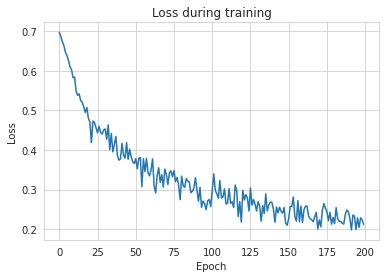

In [8]:
from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt

set_seed(42)
model = keras.Sequential()
model.add(keras.Input(shape=(X_train.shape[1],)))
model.add(layers.Dense(8, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, Y_train, epochs=200, batch_size=4, verbose=0)
sns.set_style("whitegrid")
sns.lineplot(list(range(len(history.history['loss']))), history.history['loss'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
_=plt.title("Loss during training")

The evaluation of our simple neural model yields the following results.

In [9]:
from sklearn.metrics import classification_report
from pprint import pprint
predictions = model.predict(X_test)
predictions = [np.round(x) for x in predictions]
report = classification_report(predictions, Y_test, output_dict = True)
pprint(report)

{'0.0': {'f1-score': 0.8771929824561403,
         'precision': 0.8064516129032258,
         'recall': 0.9615384615384616,
         'support': 26},
 '1.0': {'f1-score': 0.8108108108108109,
         'precision': 0.9375,
         'recall': 0.7142857142857143,
         'support': 21},
 'accuracy': 0.851063829787234,
 'macro avg': {'f1-score': 0.8440018966334756,
               'precision': 0.8719758064516129,
               'recall': 0.8379120879120879,
               'support': 47},
 'weighted avg': {'f1-score': 0.8475328632103548,
                  'precision': 0.8650051475634867,
                  'recall': 0.851063829787234,
                  'support': 47}}


The SHAP tool explores how combinations of features effectively impact model output. The final results are the features that impacted the output the most. The bar plot offers direct insight into which features were the most relevant for the neural classifier. Here, atom types 1 and 2 seem to be the most relevant when determining the mutagenicity of a molecule. The third most relevant is a wordification-constructed feature which describes a carbon atom of type 10 and charge between -0.115 and 0.1205.

In [10]:
import shap
import pandas as pd

explainer = shap.KernelExplainer(model.predict,
                                 shap.sample(pd.DataFrame(X_train, columns=feature_names), 100),
                                 link="logit")
shap_values = explainer.shap_values(pd.DataFrame(X_test, columns=feature_names),
                                    nsamples=10)

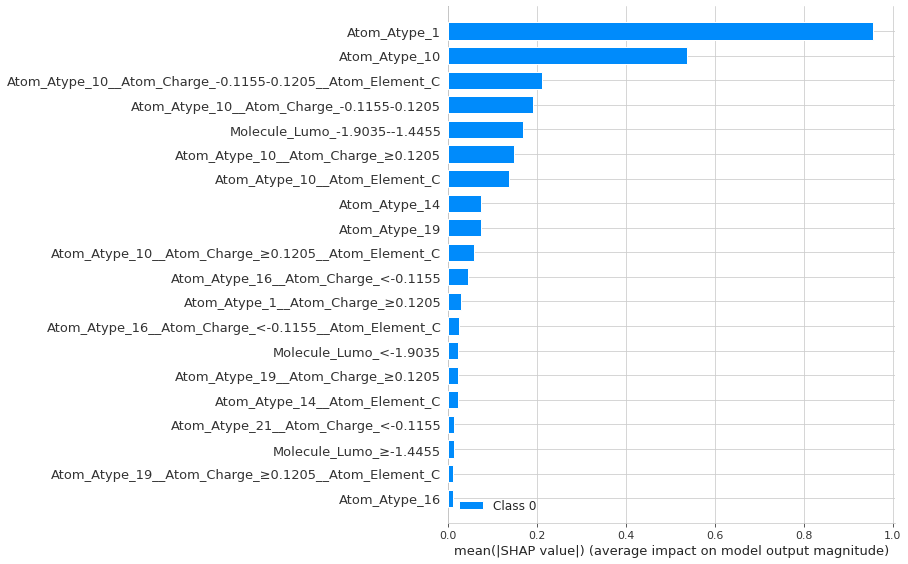

In [11]:
shap.summary_plot(shap_values, features=pd.DataFrame(X_test, columns=feature_names))